<a href="https://colab.research.google.com/github/g-e-mm/SuperStoreTimeSeries/blob/main/Super_Store_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approach To The Problem



1. Load the data and libraries
2. EDA
3. Data Preparation
4. Time Series Decomposition
  1. Trend
  2. Seasonality
  3. Irregular Component
5. Check for Staionarity(Agumented Dickey Fuller Test)
6. Moving Average
7. Exponential Smoothing : Holt & Winters
8. ARMA , ARIMA , Prophet



# Load the Libraries And Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing , Holt , SimpleExpSmoothing
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset = pd.read_csv('/content/Super_Store.csv' , encoding = 'cp1252')

In [ ]:
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

# Data Preparation

In [ ]:
dataset.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [ ]:
cols_select = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']

In [ ]:
dataset_sales = dataset.drop(cols_select , axis = 1)

In [ ]:
dataset_sales.head()

,Order Date,Sales
0,11/8/2016,261.9600
1,11/8/2016,731.9400
2,10/11/2015,957.5775
3,6/9/2014,48.8600
4,6/9/2014,1706.1840


In [ ]:
dataset_sales = dataset_sales.sort_values('Order Date')

In [ ]:
dataset_sales.head()

,Order Date,Sales
845,1/1/2017,474.430
1707,1/1/2017,141.420
1708,1/1/2017,310.744
179,1/1/2017,48.896
181,1/10/2014,51.940


In [ ]:
print(dataset_sales['Order Date'].min())
print(dataset_sales['Order Date'].max())

1/1/2017
9/9/2017


In [ ]:
dataset_sales["Order Date"] = pd.to_datetime(dataset_sales["Order Date"])
dataset_sales = dataset_sales.set_index('Order Date')

In [ ]:
dataset_sales

,Sales
Order Date,
2017-01-01,474.430
2017-01-01,141.420
2017-01-01,310.744
2017-01-01,48.896
2014-01-10,51.940
...,...
2017-09-09,66.112
2017-09-09,243.920
2017-09-09,17.024


In [ ]:
dataset_sales = dataset_sales.resample('MS').mean()
dataset_sales

,Sales
Order Date,
2014-01-01,312.126250
2014-02-01,262.808286
2014-03-01,441.635030
2014-04-01,305.570654
2014-05-01,288.032792
2014-06-01,440.204187
2014-07-01,327.910636
2014-08-01,305.014437
2014-09-01,425.294300


In [ ]:
dataset_sales.describe()

,Sales
count,48.000000
mean,346.478737
std,89.859062
min,206.044502
25%,300.079303
50%,334.581553
75%,386.478409
max,782.662773


# Visualization

<Axes: xlabel='Order Date'>

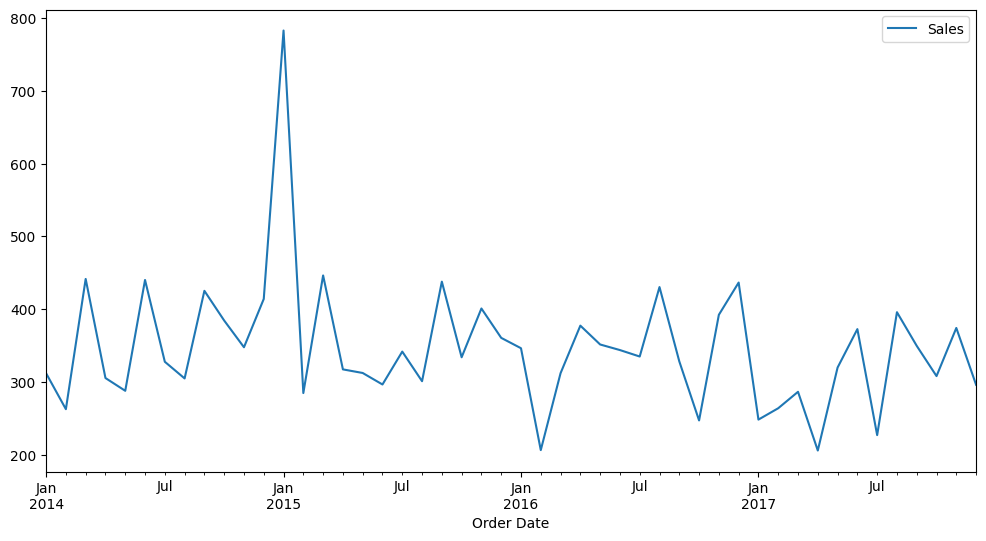

In [ ]:
dataset_sales.plot(figsize = (12,6))

# Seasonal Decompose

In [ ]:
seasonal_series = dataset_sales
result = seasonal_decompose(seasonal_series, model='additive')
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

Order Date
2014-01-01           NaN
2014-02-01           NaN
2014-03-01           NaN
2014-04-01           NaN
2014-05-01           NaN
2014-06-01           NaN
2014-07-01    374.193980
2014-08-01    394.721952
2014-09-01    395.843644
2014-10-01    396.537833
2014-11-01    398.052013
2014-12-01    393.092036
2015-01-01    387.693906
2015-02-01    388.116466
2015-03-01    388.482340
2015-04-01    386.905447
2015-05-01    387.021881
2015-06-01    387.013984
2015-07-01    366.614267
2015-08-01    345.176367
2015-09-01    336.320775
2015-10-01    333.230934
2015-11-01    337.362959
2015-12-01    340.962498
2016-01-01    342.649705
2016-02-01    347.753039
2016-03-01    348.579497
2016-04-01    340.406881
2016-05-01    336.432430
2016-06-01    339.235603
2016-07-01    338.316789
2016-08-01    336.629079
2016-09-01    337.959488
2016-10-01    329.751323
2016-11-01    321.288243
2016-12-01    321.166778
2017-01-01    317.868371
2017-02-01    311.933890
2017-03-01    311.382148
2017-04-01    

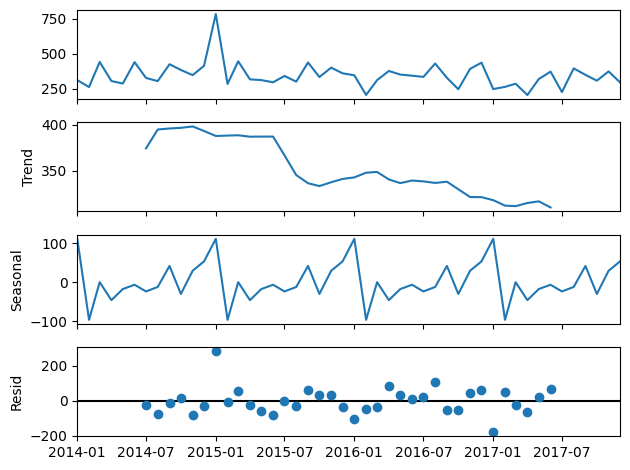

In [ ]:
seasonal_series = dataset_sales
result = seasonal_decompose(seasonal_series, model='additive')
result.plot()
plt.show()

Based on the decomposition of dataset we found that there is a trend and seasonality , therefore the dataset is not stationary.

# Agumented Dickey-Fuller Test



*   Null Hypothesis : The data is not stationary
*   Alternate Hypothesis : The data is stationary



In [ ]:
adf_test = adfuller(dataset_sales)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -6.962405
p-value: 0.000000


# AutoCorrelation

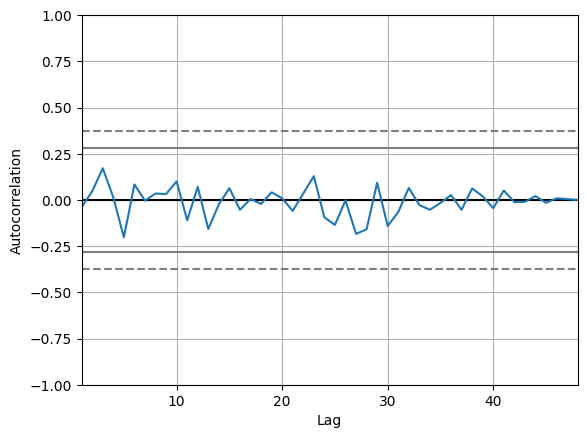

In [ ]:
autocorrelation_plot(dataset_sales)
plt.show()

# Moving Averages

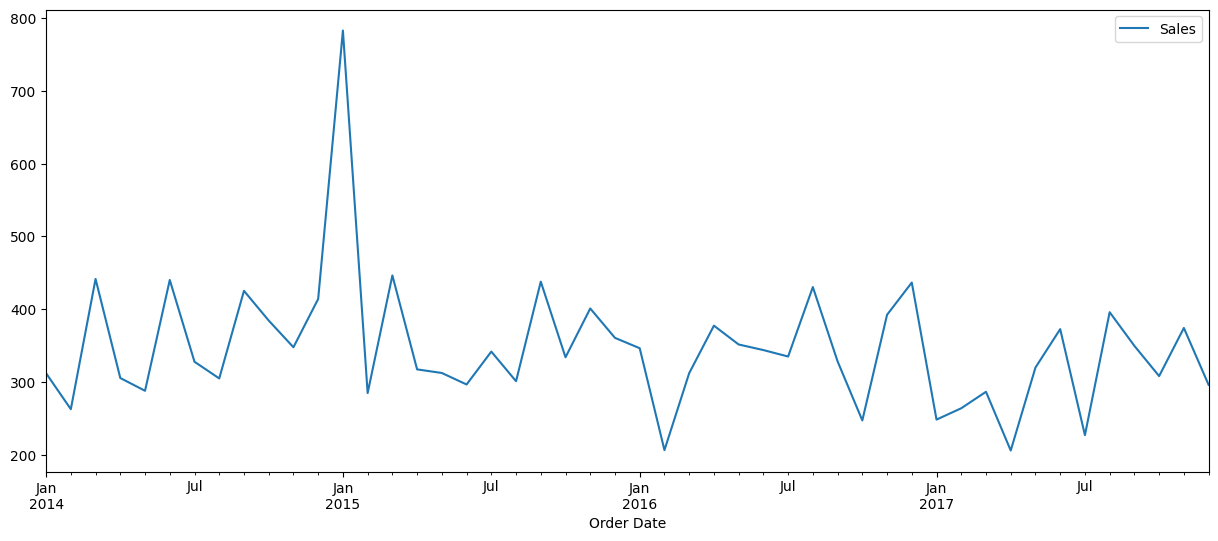

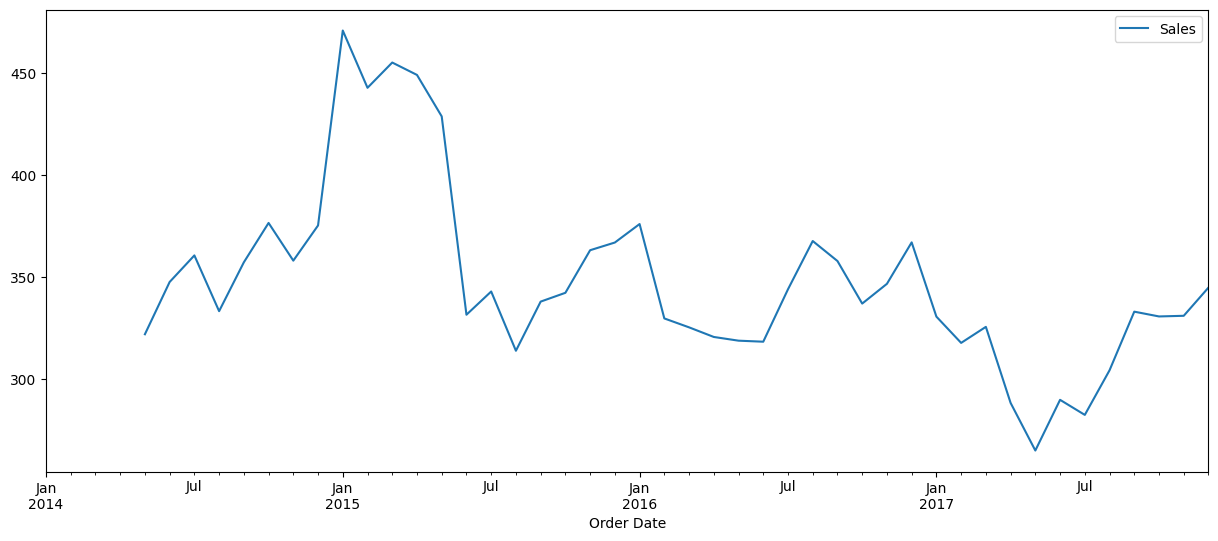

In [ ]:
#Moving Average
dataset_sales_MA = dataset_sales.rolling(window=5).mean()
dataset_sales.plot(figsize = (15,6))
dataset_sales_MA.plot(figsize = (15,6))
plt.show()

# Exponential Smoothing

## Simple Exponential Smoothing

2018-01-01    327.218973
Freq: MS, dtype: float64


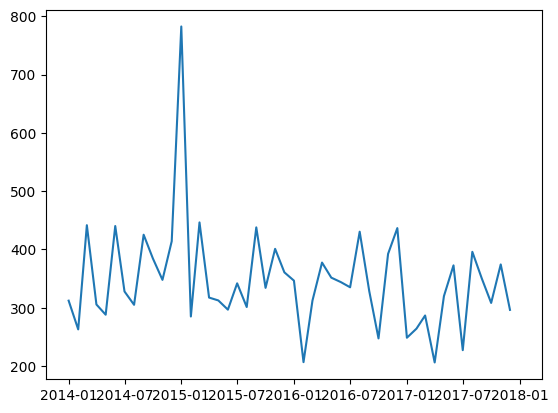

In [ ]:
# Fit Model
model = SimpleExpSmoothing(dataset_sales)
model_fit = model.fit()

# Forecast
yhat = model_fit.predict(len(dataset_sales), len(dataset_sales))
print(yhat)

#plot
plt.plot(dataset_sales)
plt.plot(yhat, color='red')
plt.show()

## Holt Winter's Exponential Smoothing

2018-01-01    370.132397
Freq: MS, dtype: float64


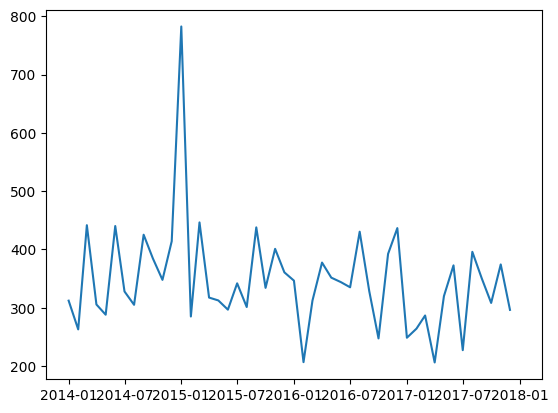

In [ ]:
# Fit Model
model = ExponentialSmoothing(dataset_sales, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecast
yhat = model_fit.predict(len(dataset_sales), len(dataset_sales))
print(yhat)

#plot
plt.plot(dataset_sales)
plt.plot(yhat, color='red')
plt.show()

# ARIMA Model

In [ ]:
model = sm.tsa.statespace.SARIMAX(dataset_sales, order=(3, 1, 3))
results = model.fit()

In [ ]:
forecast = results.predict(start = '2014-01-01', end = '2018-12-01')

In [ ]:
forecast

2014-01-01      0.000000
2014-02-01    309.499503
2014-03-01    287.630469
2014-04-01    328.364383
2014-05-01    330.093316
2014-06-01    340.264476
2014-07-01    337.296566
2014-08-01    327.120297
2014-09-01    349.472859
2014-10-01    353.040761
2014-11-01    342.442390
2014-12-01    353.941044
2015-01-01    363.649887
2015-02-01    382.971618
2015-03-01    423.999899
2015-04-01    425.153213
2015-05-01    340.543557
2015-06-01    329.555420
2015-07-01    384.659173
2015-08-01    396.863037
2015-09-01    345.895048
2015-10-01    326.517743
2015-11-01    381.184923
2015-12-01    413.075211
2016-01-01    362.513534
2016-02-01    327.317630
2016-03-01    359.105511
2016-04-01    373.898184
2016-05-01    340.102050
2016-06-01    340.104972
2016-07-01    376.169173
2016-08-01    377.078805
2016-09-01    341.147158
2016-10-01    346.826181
2016-11-01    378.336588
2016-12-01    353.213339
2017-01-01    329.881546
2017-02-01    373.528851
2017-03-01    379.930044
2017-04-01    316.348714


In [ ]:
dataset_sales

,Sales
Order Date,
2014-01-01,312.126250
2014-02-01,262.808286
2014-03-01,441.635030
2014-04-01,305.570654
2014-05-01,288.032792
2014-06-01,440.204187
2014-07-01,327.910636
2014-08-01,305.014437
2014-09-01,425.294300


# RMSE Valuation

In [ ]:
actual = dataset_sales
predicted = forecast['2014-01-01':'2017-12-01']

In [ ]:
rmse_model = np.sqrt(mean_squared_error(actual, predicted))
print("Root Mean Squared Error:" , round(rmse_model , 2))

Root Mean Squared Error: 99.82


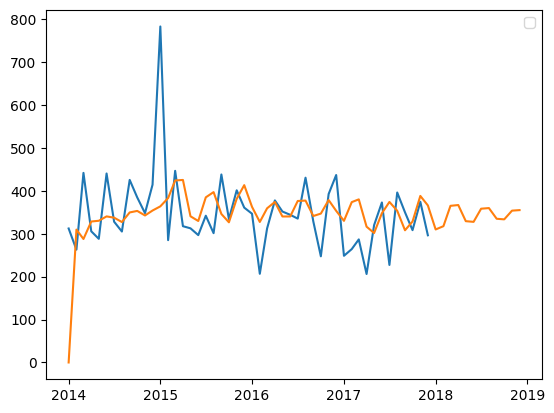

In [ ]:
plt.plot(dataset_sales)
plt.plot(forecast)
plt.legend(dataset_sales , forecast )
plt.show()

In [ ]:
# Define range for p, d, q
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

# Initialize variables to store the best parameters
best_p, best_d, best_q = 0, 0, 0
best_rmse = float('inf')

# Loop through all combinations of p, d, q
for p in p_values:
    for d in d_values:
        for q in q_values:
              # Define and fit the SARIMAX model
              model = sm.tsa.statespace.SARIMAX(dataset_sales, order=(p ,d ,q))

              model_fit = model.fit(disp=False)

              # Make predictions
              forecast = model_fit.predict(start='2014-01-01', end='2017-12-01')

              # Calculate RMSE
              rmse = np.sqrt(mean_squared_error(dataset_sales, forecast))

              # Check if this is the best combination based on RMSE
              if rmse < best_rmse:
                  best_rmse = rmse
                  best_p, best_d, best_q = p, d, q

              print(f'p={p}, d={d}, q={q}, RMSE={rmse}')

print(f'Best p, d, q: {best_p}, {best_d}, {best_q} with RMSE: {best_rmse}')

p=0, d=0, q=0, RMSE=357.706505965347
p=0, d=0, q=1, RMSE=244.71659376281005
p=0, d=0, q=2, RMSE=200.12649346436478
p=0, d=0, q=3, RMSE=193.66891006385956
p=0, d=0, q=4, RMSE=168.19804649253433
p=0, d=1, q=0, RMSE=135.55895166370362
p=0, d=1, q=1, RMSE=102.5941492979255
p=0, d=1, q=2, RMSE=102.32603831201224
p=0, d=1, q=3, RMSE=102.24479424796863
p=0, d=1, q=4, RMSE=100.77106190766212
p=0, d=2, q=0, RMSE=230.51341583207522
p=0, d=2, q=1, RMSE=145.51970411685966
p=0, d=2, q=2, RMSE=117.81897797461993
p=0, d=2, q=3, RMSE=117.63100238034198
p=0, d=2, q=4, RMSE=117.40052961524916
p=0, d=3, q=0, RMSE=415.4916002720203
p=0, d=3, q=1, RMSE=249.8734899045933
p=0, d=3, q=2, RMSE=175.6943766578489
p=0, d=3, q=3, RMSE=153.26218473098322
p=0, d=3, q=4, RMSE=152.2945663631112
p=0, d=4, q=0, RMSE=766.8768512088765
p=0, d=4, q=1, RMSE=441.31826565794694
p=0, d=4, q=2, RMSE=289.19599667888235
p=0, d=4, q=3, RMSE=226.68040945570567
p=0, d=4, q=4, RMSE=206.7326480769618
p=1, d=0, q=0, RMSE=133.5479741096

# Prophet Model

In [ ]:
dataset_prophet = dataset_sales.reset_index()
dataset_prophet.columns = ['ds','y']

In [ ]:
m = Prophet()
m.fit(dataset_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpylno3zsj/5n1mcgko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpylno3zsj/qfo5yo2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33970', 'data', 'file=/tmp/tmpylno3zsj/5n1mcgko.json', 'init=/tmp/tmpylno3zsj/qfo5yo2f.json', 'output', 'file=/tmp/tmpylno3zsj/prophet_modelns255lrj/prophet_model-20240726041856.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:18:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:18:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods = 12, freq ='MS')
future.tail()

,ds
55,2018-08-01
56,2018-09-01
57,2018-10-01
58,2018-11-01
59,2018-12-01


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,425.005922,346.777651,500.664459
1,2014-02-01,302.326201,217.349571,381.503600
2,2014-03-01,419.815100,337.708390,503.009457
3,2014-04-01,324.339485,243.708228,415.326911
4,2014-05-01,341.812990,258.675677,426.134939
5,2014-06-01,393.365880,313.438471,474.937685
6,2014-07-01,348.185074,269.317731,425.828552
7,2014-08-01,365.813358,284.005156,453.469167
8,2014-09-01,433.250421,350.440163,517.124796
9,2014-10-01,358.994401,276.420900,440.044783


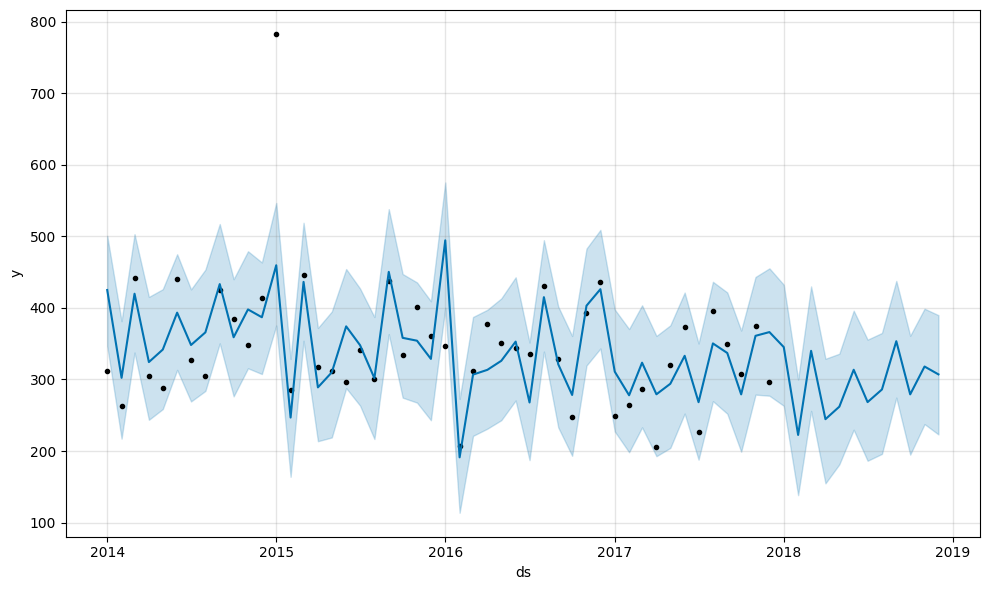

In [ ]:
fig1 = m.plot(forecast)

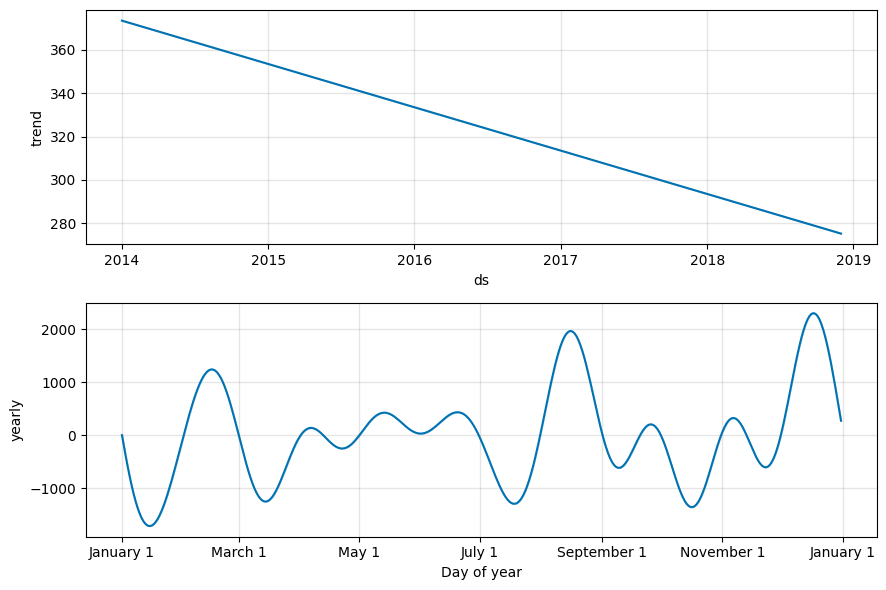

In [ ]:
fig2 = m.plot_components(forecast)